In [1]:
import mne

In [2]:
import pandas as pd

In [3]:
import json

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import matplotlib

In [7]:
%load_ext autoreload

%autoreload 2
import tools

In [8]:
import datetime as dt

In [9]:
import eeg_events

In [10]:
%matplotlib inline

# Проверка гипотезы

In [11]:
baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered-unprocessed.raw.fif", preload=True)

Opening raw data file ./valid-data/processed/test-filtered-unprocessed.raw.fif...
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Reading 0 ... 108903  =      0.000 ...   425.402 secs...


In [12]:
events_df = pd.read_csv("./valid-data/processed/events-test-filtered.csv")

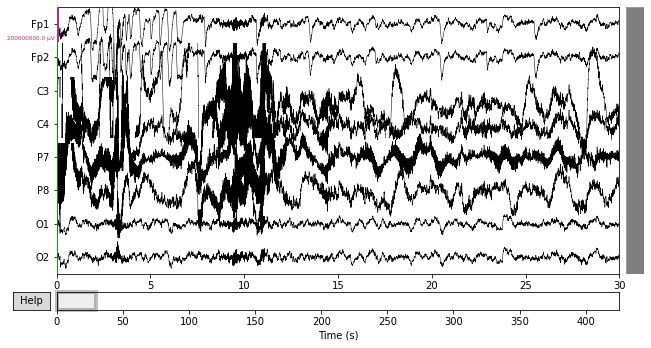

In [13]:
_ = mne.viz.plot_raw(
    baseline_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

### Добавить STI канал для фиксации событий

In [14]:
sfreq = int(baseline_raw.info["sfreq"])

In [15]:
eeg_data = baseline_raw.get_data()

In [16]:
eval(events_df["json"].iloc[3])["collect"]

True

In [17]:
# Событие - наличие или отсутствие пустой катушки в состоянии 000. Возможно - слишком близкие ивенты, сложно разделить
def check_hypothesis(response):
#     response = response["response"]
    return response.get("collect", False)
#     return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000", \
#         response["result"]['reels']['view'][0][0] == 5

In [18]:
# # Событие - состояние 000
# def check_hypothesis(response):
#     response = response["response"]
#     return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000"

In [19]:
events_df["type_proxy"] = events_df["json"].apply(lambda x: eval(x)).apply(check_hypothesis)
# events_df["type_proxy"] = [(True, x > 315 // 2) for x in events_df.index]

In [20]:
events_df["type"] = 'unknown'

In [21]:
events_df.loc[events_df["type_proxy"] == True, "type"] = 'empty reel'
events_df.loc[events_df["type_proxy"] == False, "type"] = 'another action'

In [22]:
events_df["type"].value_counts()

another action    283
empty reel         32
Name: type, dtype: int64

In [23]:
stim_channel = np.zeros(eeg_data.shape[1])

true_timestamps = (events_df[events_df["type"] == 'empty reel']["timestamp"] * sfreq).astype(int)
stim_channel[true_timestamps[true_timestamps < stim_channel.shape[0]]] = 1

false_timestamps = (events_df[events_df["type"] == 'another action']["timestamp"] * sfreq).astype(int)
stim_channel[false_timestamps[false_timestamps < stim_channel.shape[0]]] = 2

In [24]:
stim_info = mne.create_info(['STI'], baseline_raw.info['sfreq'], ['stim'])

In [25]:
stim_raw = mne.io.RawArray(stim_channel.reshape(1, -1), stim_info)

Creating RawArray with float64 data, n_channels=1, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.


In [26]:
baseline_raw.add_channels([stim_raw], force_update_info=True)

<Raw | test-filtered-unprocessed.raw.fif, 9 x 108904 (425.4 s), ~7.5 MB, data loaded>

In [27]:
events = mne.find_events(baseline_raw, stim_channel="STI")

312 events found
Event IDs: [1 2]


In [28]:
raw_part = baseline_raw.copy().pick(["Fp1", "Fp2", "O1", "O2"])

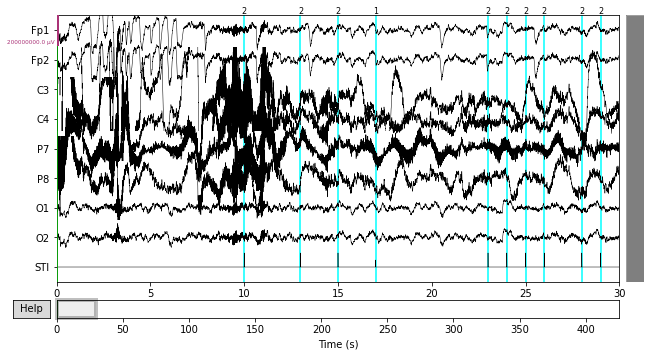

In [29]:
_ = mne.viz.plot_raw(
    baseline_raw,
    events,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

In [30]:
epochs = mne.Epochs(
    baseline_raw,
    events,
    tmin=0,
    tmax=10,
    preload=True,
    baseline=None#(None, 0)
)

Not setting metadata
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 2561 original time points ...
8 bad epochs dropped


In [31]:
epochs_part = epochs.copy().pick(["Fp1"])

Need more than one channel to make topography for eeg. Disabling interactivity.


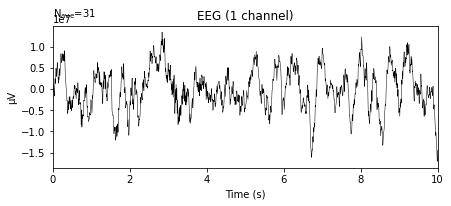

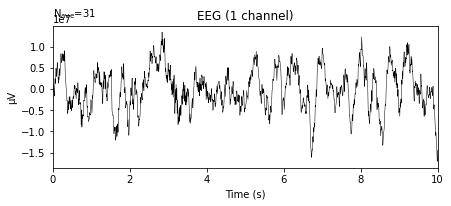

In [32]:
# Средняя попытка для пустой катушки
epochs_part['1'].average().plot()

Need more than one channel to make topography for eeg. Disabling interactivity.


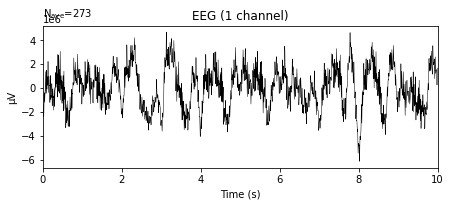

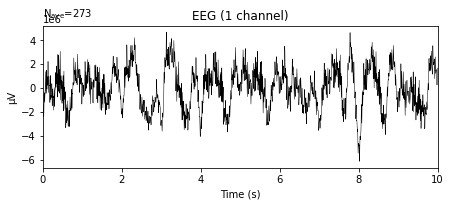

In [33]:
# Средняя попытка для других символов
epochs_part['2'].average().plot()

# Проверка гипотезы

TODO уточнить ожидаемый размер эффекта

Ожидаемый результат - для пустой катушки амплитуда альфа-ритма должна быть больше, чем для других символов

In [34]:
empty_reel_data = epochs_part['1'].get_data()

In [35]:
other_action_data = epochs_part['2'].get_data()

In [36]:
other_action_data.shape

(273, 1, 2561)

In [37]:
def filter_by_mean(data):
    mean_abs_values = np.abs(data.max(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[0:]]

In [38]:
from scipy import stats

In [39]:
def filter_by_std(data):
    mean_abs_values = (data.std(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[5:]]

In [40]:
def filter_by_kurtosis(data):
    mean_abs_values = (stats.kurtosis(data, axis=2)).max(axis=1)
    return data[np.argsort(-mean_abs_values)[10:]]

Simplest filtering

In [42]:
# empty_reel_data = filter_by_kurtosis(empty_reel_data)
other_action_data = filter_by_kurtosis(other_action_data)

In [43]:
import seaborn as sns

In [44]:
import plotly.express as px

/home/anatoli/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/anatoli/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [45]:
# plt.figure(figsize=(20, 10))
# plt.plot(other_action_data.reshape(other_action_data.shape[0], -1).T, color='blue')
# plt.plot(empty_reel_data.reshape(empty_reel_data.shape[0], -1).T, color='red')
# plt.show()

In [46]:
empty_reel_data.shape

(31, 1, 2561)

In [47]:
empty_reel_frequencies = np.abs(np.fft.fft(empty_reel_data, 256, axis=-1))[:, :, 0:30]

In [48]:
import seaborn as sns

In [49]:
empty_reel_frequencies.mean(axis=0)

array([[1137.12464216, 2516.74307213, 1966.84778716, 1157.43684481,
         847.3989167 ,  692.8786436 ,  521.93702357,  546.8287499 ,
         332.10352192,  397.56308979,  328.64313794,  247.26753041,
         248.51511643,  209.42041546,  200.02928633,  173.8877138 ,
         194.2870431 ,  161.16989966,  166.30845724,  134.27915811,
         141.55645047,  120.94543261,  108.822514  ,  154.32656035,
         138.78520655,  118.91282431,  144.78319835,  126.49878368,
         126.45577986,  136.75672871]])

In [50]:
other_frequencies = np.abs(np.fft.fft(other_action_data, 256, axis=-1))[:, :, 0:30]

3. EEG mid-beta activity in the left frontal region of the brain is lower in the 
flow state than in the boredom state.

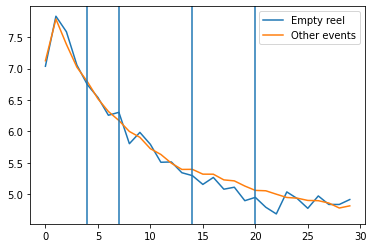

In [51]:
plt.plot(np.log(empty_reel_frequencies[:, 0, :].mean(axis=0)), label="Empty reel")
plt.plot(np.log(other_frequencies[:, 0, :].mean(axis=0)), label="Other events")
plt.axvline(4)
plt.axvline(7)
plt.axvline(14)
plt.axvline(20)
plt.legend()

In [52]:
other_frequencies.mean(axis=0)

array([[1241.07736985, 2406.99554437, 1610.12431922, 1119.91163282,
         889.52395373,  678.3720484 ,  554.26107231,  480.25180972,
         403.38635155,  367.59244513,  306.7995719 ,  279.92880536,
         243.7587655 ,  220.65401057,  221.00494261,  204.70508556,
         204.53307791,  186.90926339,  183.95765151,  169.43329168,
         158.15283242,  157.16314459,  148.85536635,  141.30509975,
         139.75902275,  134.81732364,  134.29126067,  129.3839681 ,
         119.51983414,  123.71962673]])

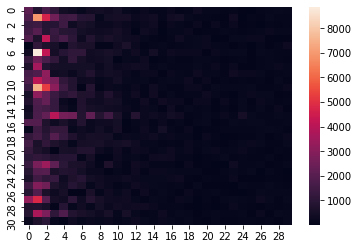

In [53]:
sns.heatmap(empty_reel_frequencies.mean(axis=1))

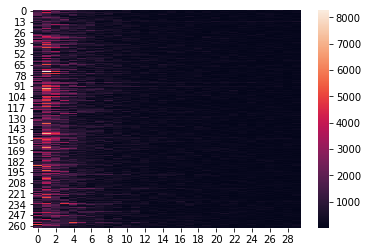

In [54]:
sns.heatmap(other_frequencies.mean(axis=1))

In [55]:
sample_empty = empty_reel_frequencies[:, :, 15:20].mean(axis=-1).mean(axis=-1)

In [56]:
sample_other = other_frequencies[:, :, 15:20].mean(axis=-1).mean(axis=-1)

In [57]:
# sample_empty = empty_reel_data.mean(axis=2).mean(axis=1) #.std(axis=2).mean(axis=1)

In [58]:
# sample_other = other_action_data.mean(axis=2).mean(axis=1)

(array([0.00221544, 0.00443087, 0.00443087, 0.01550805, 0.00664631,
        0.00886174, 0.01107718, 0.00664631, 0.        , 0.00221544,
        0.00221544, 0.00443087, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([ 86.9503584 , 101.51095703, 116.07155566, 130.63215429,
        145.19275293, 159.75335156, 174.31395019, 188.87454882,
        203.43514745, 217.99574609, 232.55634472, 247.11694335,
        261.67754198, 276.23814061, 290.79873924, 305.35933788,
        319.91993651, 334.48053514, 349.04113377, 363.6017324 ]),
 <a list of 19 Patch objects>)

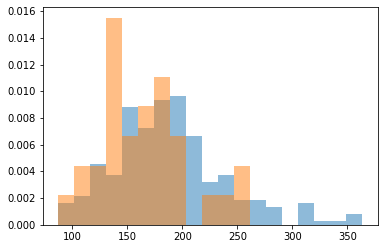

In [59]:
bins=np.linspace(np.quantile(sample_other, 0.01), np.quantile(sample_other, 0.99), 20)
plt.hist(sample_other, bins=bins, alpha=0.5, density=True)
plt.hist(sample_empty, bins=bins, alpha=0.5, density=True)

In [60]:
from scipy.stats import mannwhitneyu

In [61]:
from scipy.stats import ttest_ind

In [62]:
sample_other.mean()

189.90767401179644

In [63]:
sample_empty.mean()

165.9864543826608

In [64]:
ttest_ind(sample_other, sample_empty)

Ttest_indResult(statistic=2.2573954398665754, pvalue=0.02472207722846898)

In [65]:
mannwhitneyu(sample_other, sample_empty)

MannwhitneyuResult(statistic=2918.0, pvalue=0.0048463869314996555)